Intital Setup

In [0]:
## All import statements goes here 
import os
import sys
sys.path.insert(1, 'crfasrnn_keras/src')
import random
import warnings
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#import cv2

from tqdm import tqdm_notebook, tnrange
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input, Dropout
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

from crfrnn_model import get_crfrnn_model_def

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [0]:
DATA_TRAIN = '/content/tgs-salt-identification-challenge/train'

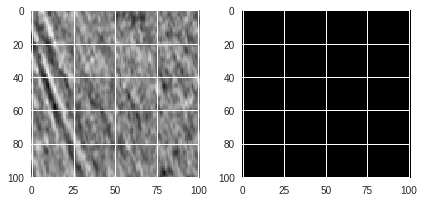

In [0]:
## EDA
train_image_ids = os.listdir(os.path.join(DATA_TRAIN,'images'))
random_image_idx = np.random.randint(0,len(train_image_ids))
random_image = imread(os.path.join(DATA_TRAIN,'images/'+train_image_ids[random_image_idx]))
random_mask = imread(os.path.join(DATA_TRAIN,'masks/'+train_image_ids[random_image_idx]))
plt.subplot(1,2,1)
plt.imshow(random_image)
plt.subplot(1,2,2)
imshow(random_mask)
plt.show()

In [0]:
def cov_to_class(val):    
    for i in range(0, 11):
        if val * 10 <= i :
            return i

In [0]:
## Getting and resizing the training images 
## also calculate the coverage
IMAGE_DIMENSION = (128,128,1)  # HEIGHT X WIDTH X CHANNEL 
MASK_DIMENSION = (128,128,1) # HEIGHT X WIDTH
images = np.zeros((2*len(train_image_ids), 128,128,1),dtype=np.uint8)
masks = np.zeros((2*len(train_image_ids), 128,128,1),dtype=np.bool)
coverage_classes = []
coverage = []
#coverage = []
for i,curr_id in enumerate(train_image_ids):
    # Load the current image
    
    current_image = img_to_array(imread(os.path.join(DATA_TRAIN,'images/'+curr_id)))
    current_mask = img_to_array(imread(os.path.join(DATA_TRAIN,'masks/'+curr_id),as_gray=True))  
    
    # Resize the current image
    
    resized_image = resize(current_image, IMAGE_DIMENSION, mode='constant', preserve_range=True)
    resized_mask = resize(current_mask, MASK_DIMENSION, mode='constant', preserve_range=True)
    
    # Add the resized image to the list
    
    images[2*i] = resized_image
    masks[2*i] = resized_mask
    
    # Add augmented image to the list 
    
    images[2*i+1] = np.fliplr(images[2*i])
    masks[2*i+1] = np.fliplr(masks[2*i])
   
    
    # Calculate coverage 
    
    coverage.append(np.sum(current_mask/65535)/(101*101))
    coverage_classes.append(cov_to_class(coverage[-1]))
    
    coverage.append(coverage[-1])
    coverage_classes.append(coverage_classes[-1])


In [0]:
print images[0].shape
#sns.distplot(coverage_classes, bins=10, kde=False)

(128, 128, 1)


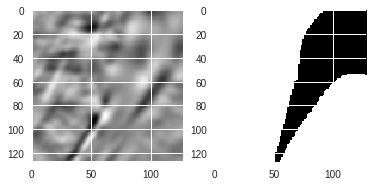

In [0]:
random_image_idx = np.random.randint(0,len(images))
plt.subplot(1,2,1)
plt.imshow(images[random_image_idx][:,:,0],cmap=plt.cm.binary)
plt.subplot(1,2,2)
plt.imshow(masks[random_image_idx][:,:,0],cmap=plt.cm.binary)
plt.show()

In [0]:
## Load the depth data
DEPTH_FILE = '/content/tgs-salt-identification-challenge/depths.csv'
depth_df = pd.read_csv(DEPTH_FILE)
depth_df.head()

,id,z
0,4ac19fb269,306
1,1825fadf99,157
2,f59821d067,305
3,5b435fad9d,503
4,e340e7bfca,783


Text(0.5,0.98,u'Green: salt. Top-left: coverage class, top-right: salt coverage, bottom-left: depth')

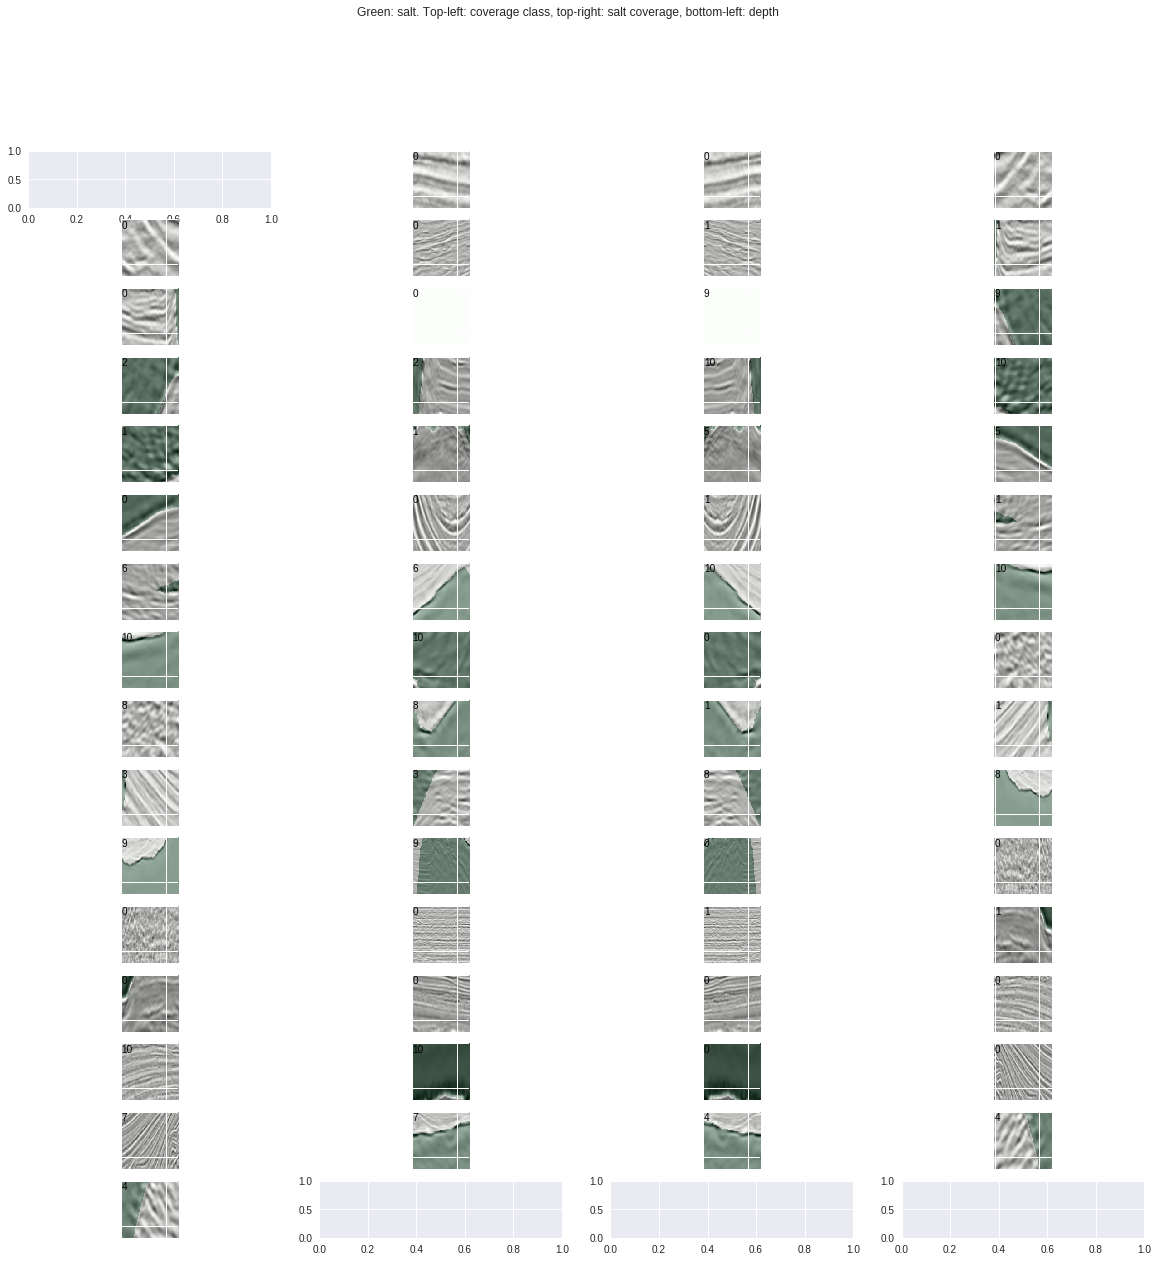

In [0]:
max_images = 60
grid_width = 4
img_size_ori = 128
grid_height = int(max_images / grid_width)

fig, axs = plt.subplots(grid_height+1, grid_width, figsize=(20, 20))
i = 0
for img,mask in zip(images[:max_images],masks[:max_images]):
    i = i+1
    ax = axs[int(i / grid_width), i % grid_width]
    #print np.rollaxis(img, 2, 0).shape,np.rollaxis(mask, 2, 0).shape
    #print img.shape, mask.shape
    ax.imshow(img[:,:,0], cmap="Greys")
    ax.imshow(mask[:,:,0], alpha=0.3, cmap="Greens")
    #ax.text(1, img_size_ori-1, depth color="black")
    #ax.text(img_size_ori - 1, 1, coverage, 2), color="black", ha="right", va="top")
    ax.text(1, 1, coverage_classes[i], color="black", ha="left", va="top")
    ax.set_yticklabels([])
    ax.set_xticklabels([])
plt.suptitle("Green: salt. Top-left: coverage class, top-right: salt coverage, bottom-left: depth")

In [0]:
## Define IoU metrics
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [0]:
# Build U-Net model
inputs = Input(IMAGE_DIMENSION)
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='relu', padding='same') (s)
c1 = Conv2D(16, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)
p1 = Dropout(0.25)(p1)

c2 = Conv2D(16*2, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16*2, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)
p2 = Dropout(0.5)(p2)

c3 = Conv2D(16*4, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(16*4, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)
p3 = Dropout(0.5)(p3)

c4 = Conv2D(16*8, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(16*8, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
p4 = Dropout(0.5)(p4)

c5 = Conv2D(16*16, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(16*16, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(16*8, (3, 3), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
u6 = Dropout(0.5)(u6)
c6 = Conv2D(16*8, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(16*8, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(16*4, (3, 3), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
u7 = Dropout(0.5)(u7)
c7 = Conv2D(16*4, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(16*4, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16*2, (3, 3), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
u8 = Dropout(0.5)(u8)
c8 = Conv2D(16*2, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16*2, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(16*1, (3, 3), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
u9 = Dropout(0.5)(u9)
c9 = Conv2D(16*1, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(16*1, (3, 3), activation='relu', padding='same') (c9)

c9 = Dropout(0.5)(c9)
outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128, 128, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 160         lambda_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 16) 2320        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [0]:
import matplotlib.pyplot as plt
from keras.callbacks import Callback
from IPython.display import clear_output
#from matplotlib.ticker import FormatStrFormatter

def translate_metric(x):
    translations = {'acc': "Accuracy", 'loss': "Log-loss (cost function)"}
    if x in translations:
        return translations[x]
    else:
        return x

class PlotLosses(Callback):
    def __init__(self, figsize=None):
        super(PlotLosses, self).__init__()
        self.figsize = figsize

    def on_train_begin(self, logs={}):

        self.base_metrics = [metric for metric in self.params['metrics'] if not metric.startswith('val_')]
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs.copy())

        clear_output(wait=True)
        plt.figure(figsize=self.figsize)
        
        for metric_id, metric in enumerate(self.base_metrics):
            plt.subplot(1, len(self.base_metrics), metric_id + 1)
            
            plt.plot(range(1, len(self.logs) + 1),
                     [log[metric] for log in self.logs],
                     label="training")
            if self.params['do_validation']:
                plt.plot(range(1, len(self.logs) + 1),
                         [log['val_' + metric] for log in self.logs],
                         label="validation")
            plt.title(translate_metric(metric))
            plt.xlabel('epoch')
            plt.legend(loc='center left')
        
        plt.tight_layout()
        plt.show();

plot_losses = PlotLosses(figsize=(16, 4))

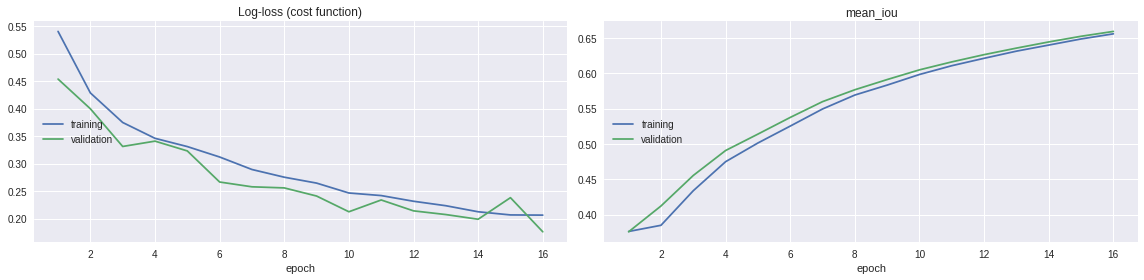

Epoch 17/200
4544/6400 [====================>.........] - ETA: 14s - loss: 0.2022 - mean_iou: 0.6618

In [0]:
earlystopper = EarlyStopping(patience=10, verbose=1)
checkpointer = ModelCheckpoint('model-tgs-salt-1.h5', verbose=1, save_best_only=True)
results = model.fit(images, masks, validation_split=0.2, batch_size=32, epochs=200, callbacks=[earlystopper, checkpointer, plot_losses])

In [0]:
## Getting the Test Data and resizing it
DATA_TEST = '/content/tgs-salt-identification-challenge/test'
image_ids = os.listdir(os.path.join(DATA_TEST,'images'))
images_test = np.zeros((len(image_ids), 128,128,1),dtype=np.uint8)
test_size = []
for i,curr_id in enumerate(image_ids):
    # Load the current image
    current_image = img_to_array(imread(os.path.join(DATA_TEST,'images/'+curr_id)))
    test_size.append((current_image.shape[0],current_image.shape[1]))
    # Resize the current image
    resized_image = resize(current_image, IMAGE_DIMENSION, mode='constant', preserve_range=True)
    # Add the resized image to the list
    images_test[i] = resized_image

In [0]:
## Predict on train, validation and test set
model = load_model('model-tgs-salt-1.h5', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(images[:int(images.shape[0]*0.9)], verbose=1)
preds_val = model.predict(images[int(images.shape[0]*0.9):], verbose=1)
preds_test = model.predict(images_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

15072/18000 [========================>.....] - ETA: 6s

18000/18000 [==============================] - 38s 2ms/step


In [0]:
## Upsampling images
upsampled_images = []
for i,test_mask in enumerate(preds_test_t):
  upsampled_images.append(resize(test_mask, test_size[i], mode='constant',preserve_range=True))

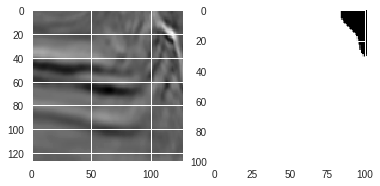

In [0]:
## Visualizing test data prediction
random_index = np.random.randint(0,len(upsampled_images))
random_image = images_test[random_index]
random_predicted_mask = upsampled_images[random_index]
plt.subplot(1,2,1)
plt.imshow(np.squeeze(random_image))
plt.subplot(1,2,2)
plt.imshow(np.squeeze(random_predicted_mask))
plt.show()

In [0]:
## Run Length Encoding Algorithm
def RLenc(img, order='F', format=True):
    """
    img: is binary mask image, shape (r,c)
    order: is down-then-right, i.e. Fortran
    format: determines if the order needs to be preformatted (according to submission rules) or not
    returns: run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs

pred_dict = {fn[:-4]:RLenc(np.round(upsampled_images[i])) for i,fn in enumerate(image_ids)}

In [0]:
timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M")
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
file_name = 'submission-{}.csv'.format(timestamp)
print('saving submission {}'.format(file_name))
sub.to_csv(file_name)

saving submission submission-20180727-0644.csv
